## TabNet

In [1]:
!pip -q install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from scipy import stats
from scipy.stats import norm
from joblib import Parallel, delayed

import shutil
import glob

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts


# setting some globl config

plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

In [3]:
import psutil
def read_train_test():
    # Function to read our base train and test set
    
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    print(f'Our test set has {test.shape[0]} rows')
    print(f'Our training set has {train.isna().sum().sum()} missing values')
    print(f'Our test set has {test.isna().sum().sum()} missing values')
    
    return train, test
train, test = read_train_test()

Our training set has 428932 rows
Our test set has 3 rows
Our training set has 0 missing values
Our test set has 0 missing values


In [4]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

def calc_wap1(df):
    # Function to calculate first WAP
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    # Function to calculate second WAP
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    # Function to calculate the log of the return
    return np.log(series).diff()

def realized_volatility(series):
    # Calculate the realized volatility
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    # Function to count unique elements of a series
    return len(np.unique(series))

def book_preprocessor(file_path):
    # Function to preprocess book data (for each stock id)
    
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
        
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    return df_feature


def trade_preprocessor(file_path):
    # Function to preprocess trade data (for each stock id)
    
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, realized_volatility, np.mean, np.std, np.max, np.min],
        'order_count':[np.mean,np.sum,np.max],
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
        
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200','time_id'], axis = 1, inplace = True)
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    
    def order_sum(df, sec:str):
        new_col = 'size_tau' + sec
        bucket_col = 'trade_seconds_in_bucket_count_unique' + sec
        df[new_col] = np.sqrt(1/df[bucket_col])
        
        new_col2 = 'size_tau2' + sec
        order_col = 'trade_order_count_sum' + sec
        df[new_col2] = np.sqrt(1/df[order_col])
        
        if sec == '400_':
            df['size_tau2_d'] = df['size_tau2_400'] - df['size_tau2']
        

    
    for sec in ['','_200','_300','_400']:
        order_sum(df_feature, sec)
        
    df_feature['size_tau2_d'] = df_feature['size_tau2_400'] - df_feature['size_tau2']
    
    return df_feature


def get_time_stock(df):
    # Function to get group stats for the stock_id and time_id
    
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    
    return df

def create_agg_features(train, test):

    # Making agg features

    train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')
    corr = train_p.corr()
    ids = corr.index
    kmeans = KMeans(n_clusters=7, random_state=42).fit(corr.values)
    l = []
    for n in range(7):
        l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )

    mat = []
    matTest = []
    n = 0
    for ind in l:
        newDf = train.loc[train['stock_id'].isin(ind) ]
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        mat.append ( newDf )
        newDf = test.loc[test['stock_id'].isin(ind) ]    
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        matTest.append ( newDf )
        n+=1

    mat1 = pd.concat(mat).reset_index()
    mat1.drop(columns=['target'],inplace=True)
    mat2 = pd.concat(matTest).reset_index()
    
    mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
    
    mat1 = mat1.pivot(index='time_id', columns='stock_id')
    mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
    mat1.reset_index(inplace=True)
    
    mat2 = mat2.pivot(index='time_id', columns='stock_id')
    mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
    mat2.reset_index(inplace=True)
    
    prefix = ['log_return1_realized_volatility', 'total_volume_mean', 'trade_size_mean', 'trade_order_count_mean','price_spread_mean','bid_spread_mean','ask_spread_mean',
              'volume_imbalance_mean', 'bid_ask_spread_mean','size_tau2']
    selected_cols=mat1.filter(regex='|'.join(f'^{x}.(0|1|3|4|6)c1' for x in prefix)).columns.tolist()
    selected_cols.append('time_id')
    
    train_m = pd.merge(train,mat1[selected_cols],how='left',on='time_id')
    test_m = pd.merge(test,mat2[selected_cols],how='left',on='time_id')
    
    # filling missing values with train means

    features = [col for col in train_m.columns.tolist() if col not in ['time_id','target','row_id']]
    train_m[features] = train_m[features].fillna(train_m[features].mean())
    test_m[features] = test_m[features].fillna(train_m[features].mean())

    return train_m, test_m
    
    
def preprocessor(list_stock_ids, is_train = True):
    # Funtion to make preprocessing function in parallel (for each stock id)
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    
    return df

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Fill inf values
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)

# Aggregating some features
train, test = create_agg_features(train,test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 26.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [5]:
import os
for fold in range(5):
    !cp -r ../input/optiver-tabnet-models/fold{str(fold)}/* .
    !zip fold{str(fold)}.zip model_params.json network.pt
    
modelpath = [os.path.join("./",s) for s in os.listdir("./") if ("zip" in s)]  

  adding: model_params.json (deflated 45%)
  adding: network.pt (deflated 20%)
  adding: model_params.json (deflated 45%)
  adding: network.pt (deflated 20%)
  adding: model_params.json (deflated 45%)
  adding: network.pt (deflated 20%)
  adding: model_params.json (deflated 45%)
  adding: network.pt (deflated 20%)
  adding: model_params.json (deflated 45%)
  adding: network.pt (deflated 20%)


In [6]:
X = train.drop(['row_id', 'target', 'time_id'], axis = 1)
y = train['target']
X_test=test.copy()
X_test.drop(['time_id','row_id'], axis=1,inplace=True)

def rmspe(y_true, y_pred):
    # Function to calculate the root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))
    


def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()

nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}

for col in X.columns:
    if  col == 'stock_id':
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
        


cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    n_d = 16,
    n_a = 16,
    n_steps = 2,
    gamma = 2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    mask_type = "entmax",
    scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
    
)

# kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# # Create out of folds array
# oof_predictions = np.zeros((X.shape[0], 1))
# test_predictions = np.zeros(X_test.shape[0])
# feature_importances = pd.DataFrame()
# feature_importances["feature"] = X.columns.tolist()
# stats = pd.DataFrame()
# explain_matrices = []
# masks_ =[]

clf =  TabNetRegressor(**tabnet_params)

# for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
#     print(f'Training fold {fold + 1}')
#     X_train, X_val = X.iloc[trn_ind].values, X.iloc[val_ind].values
#     y_train, y_val = y.iloc[trn_ind].values.reshape(-1,1), y.iloc[val_ind].values.reshape(-1,1)


    
#     clf.fit(
#       X_train, y_train,
#       eval_set=[(X_val, y_val)],
#       max_epochs = 200,
#       patience = 50,
#       batch_size = 1024*20, 
#       virtual_batch_size = 128*20,
#       num_workers = 4,
#       drop_last = False,
#       eval_metric=[RMSPE],
#       loss_fn=RMSPELoss
#       )
    
#     saving_path_name = f"./fold{fold}"
#     saved_filepath = clf.save_model(saving_path_name)
    
#     explain_matrix, masks = clf.explain(X_val)
#     explain_matrices.append(explain_matrix)
#     masks_.append(masks[0])
#     masks_.append(masks[1])
      
#     oof_predictions[val_ind] = clf.predict(X_val)
#     test_predictions+=clf.predict(X_test.values).flatten()/5
#     feature_importances[f"importance_fold{fold}+1"] = clf.feature_importances_
    
#     stats[f'fold{fold+1}_train_rmspe']=clf.history['loss']
#     stats[f'fold{fold+1}_val_rmspe']=clf.history['val_0_rmspe']
preds=[]
for path in modelpath:
    
    clf.load_model(path)
    preds.append(clf.predict(X_test.values).squeeze(-1))
    
model1_predictions = np.mean(preds,axis=0)

Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu


## NN
https://www.kaggle.com/lucasmorin/tf-keras-nn-with-stock-embedding

A simple NN starter using stock Embedding.

Embedding layer from : https://www.kaggle.com/colinmorris/embedding-layers

--- Features from ---

https://www.kaggle.com/ragnar123/optiver-realized-volatility-lgbm-baseline but I have optimized the LGB params.

In [7]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

## Train and test datasets

In [8]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'
# Calculate the realized absolute variation
def realized_absvar(series):
    return np.sqrt(np.pi/(2*series.count()))*np.sum(np.abs(series))
# realized bipower variation 
def realized_bipowvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/2)*(cnt/(cnt-2))
        return cons*np.nansum(np.abs(series)*np.abs(series.shift()))
# Calculate order book depth
def calc_depth(df):
    depth = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1'] + df['bid_price2'] * df[
               'bid_size2'] + df['ask_price2'] * df['ask_size2']
    return depth
# Calculate order book slope
def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df[
        'ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)
# Calculate order book dispersion
def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return bspread, aspread, bmid, amid, bdisp, adisp, (bdisp + adisp)/2, (bdisp2 + adisp2)/2
def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']
#  order flow imbalance
def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    #calc_depth
    df['calc_depth']=calc_depth(df)
    #calc_slope
    df['calc_slope1'],df['calc_slope2']=calc_slope(df)
    #calc_dispersion
    df['bspread'], df['aspread'], df['bmid'], df['amid'], df['bdisp'], df['adisp'], df['a_bdisp_1'], df['ba_disp2'] = calc_dispersion(df)
    #calc_price_impact
    df['calc_price_impact1'],df['calc_price_impact2']=calc_price_impact(df)
    #calc_ofi
    df['calc_ofi']=calc_ofi(df)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {

        'calc_depth':[np.sum, np.mean, np.std],
        'calc_slope1':[np.sum, np.mean, np.std],
        'calc_slope2':[np.sum, np.mean, np.std],
        'calc_price_impact1':[np.sum, np.mean, np.std],
        'calc_price_impact2':[np.sum, np.mean, np.std],
        'calc_ofi':[np.sum, np.mean, np.std],
        
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std, realized_absvar, realized_bipowvar],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std, realized_absvar, realized_bipowvar],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility,realized_absvar,realized_bipowvar],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, realized_volatility, np.mean, np.std, np.max, np.min],
        'order_count':[np.mean,np.sum,np.max],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150','time_id'], axis = 1, inplace = True)
    
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']
#     vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility',
#                 'log_return1_realized_volatility_600', 'log_return2_realized_volatility_600', 
#                 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
# #                 'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 
#                 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200',
# #                 'log_return1_realized_volatility_100', 'log_return2_realized_volatility_100', 
#                 'trade_log_return_realized_volatility',
#                 'trade_log_return_realized_volatility_600', 
#                 'trade_log_return_realized_volatility_400',
# #                 'trade_log_return_realized_volatility_300',
# #                 'trade_log_return_realized_volatility_100',
#                 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [9]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)


Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 63.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [10]:
train.to_pickle('dataset_baseline_train_best.pkl')
test.to_pickle('dataset_baseline_test_best.pkl')

In [11]:
list(train)

['stock_id',
 'time_id',
 'target',
 'row_id',
 'calc_depth_sum',
 'calc_depth_mean',
 'calc_depth_std',
 'calc_slope1_sum',
 'calc_slope1_mean',
 'calc_slope1_std',
 'calc_slope2_sum',
 'calc_slope2_mean',
 'calc_slope2_std',
 'calc_price_impact1_sum',
 'calc_price_impact1_mean',
 'calc_price_impact1_std',
 'calc_price_impact2_sum',
 'calc_price_impact2_mean',
 'calc_price_impact2_std',
 'calc_ofi_sum',
 'calc_ofi_mean',
 'calc_ofi_std',
 'wap1_sum',
 'wap1_mean',
 'wap1_std',
 'wap2_sum',
 'wap2_mean',
 'wap2_std',
 'log_return1_sum',
 'log_return1_realized_volatility',
 'log_return1_mean',
 'log_return1_std',
 'log_return1_realized_absvar',
 'log_return1_realized_bipowvar',
 'log_return2_sum',
 'log_return2_realized_volatility',
 'log_return2_mean',
 'log_return2_std',
 'log_return2_realized_absvar',
 'log_return2_realized_bipowvar',
 'wap_balance_sum',
 'wap_balance_mean',
 'wap_balance_std',
 'price_spread_sum',
 'price_spread_mean',
 'price_spread_std',
 'price_spread2_sum',
 'pr

In [12]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )


In [13]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_450'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_450'] - test['size_tau2']

In [14]:
train['book_BPV_jump1'] = train['log_return1_realized_volatility'] - train['log_return1_realized_bipowvar'].values
train['book_BPV_jump1'] = np.where(train['book_BPV_jump1']<0, 0, train['book_BPV_jump1'])

test['book_BPV_jump1'] = test['log_return1_realized_volatility'] - test['log_return1_realized_bipowvar'].values
test['book_BPV_jump1'] = np.where(test['book_BPV_jump1']<0, 0, test['book_BPV_jump1'])

# Training model and making predictions

In [15]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K

In [16]:
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [17]:
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=7, verbose=0,
    mode='min')

In [18]:
colNames = list(train)

colNames.remove('time_id')
colNames.remove('target')
colNames.remove('row_id')
colNames.remove('stock_id')

In [19]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []

for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=42,n_quantiles=1000, output_distribution='normal')
    train[col] = qt.fit_transform(train[[col]])
    test[col] = qt.transform(test[[col]])    
    qt_train.append(qt)

In [20]:
from sklearn.cluster import KMeans

In [21]:
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [22]:
matTest = []
mat = []
kmeans = []

In [23]:
#mat2 #= mat1.pivot(index='time_id', columns='stock_idmat2
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

In [24]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

In [25]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_mean_0c1',
     'total_volume_mean_1c1', 
     'total_volume_mean_3c1',
     'total_volume_mean_4c1', 
     'total_volume_mean_6c1',
     'trade_size_mean_0c1',
     'trade_size_mean_1c1', 
     'trade_size_mean_3c1',
     'trade_size_mean_4c1', 
     'trade_size_mean_6c1',
     'trade_order_count_mean_0c1',
     'trade_order_count_mean_1c1',
     'trade_order_count_mean_3c1',
     'trade_order_count_mean_4c1',
     'trade_order_count_mean_6c1',      
     'price_spread_mean_0c1',
     'price_spread_mean_1c1',
     'price_spread_mean_3c1',
     'price_spread_mean_4c1',
     'price_spread_mean_6c1',   
     'bid_spread_mean_0c1',
     'bid_spread_mean_1c1',
     'bid_spread_mean_3c1',
     'bid_spread_mean_4c1',
     'bid_spread_mean_6c1',       
     'ask_spread_mean_0c1',
     'ask_spread_mean_1c1',
     'ask_spread_mean_3c1',
     'ask_spread_mean_4c1',
     'ask_spread_mean_6c1',   
     'volume_imbalance_mean_0c1',
     'volume_imbalance_mean_1c1',
     'volume_imbalance_mean_3c1',
     'volume_imbalance_mean_4c1',
     'volume_imbalance_mean_6c1',       
     'bid_ask_spread_mean_0c1',
     'bid_ask_spread_mean_1c1',
     'bid_ask_spread_mean_3c1',
     'bid_ask_spread_mean_4c1',
     'bid_ask_spread_mean_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

In [26]:
#import copy
#trainCopy = copy.copy(train)
#testCopy = copy.copy(test)

#train = copy.copy(trainCopy)
#test = copy.copy(trainCopy)

In [27]:
train = pd.merge(train,mat1[nnn],how='left',on='time_id')

In [28]:
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [29]:
mat1= []
mat2= []

In [30]:
test.head()

,stock_id,time_id,row_id,calc_depth_sum,calc_depth_mean,calc_depth_std,calc_slope1_sum,calc_slope1_mean,calc_slope1_std,calc_slope2_sum,...,bid_ask_spread_mean_0c1,bid_ask_spread_mean_1c1,bid_ask_spread_mean_3c1,bid_ask_spread_mean_4c1,bid_ask_spread_mean_6c1,size_tau2_0c1,size_tau2_1c1,size_tau2_3c1,size_tau2_4c1,size_tau2_6c1
0,0,4,0-4,-5.199338,-0.864069,-2.941674,-2.786773,-3.095377,-2.243477,-3.830389,...,NaN,NaN,0.816375,NaN,NaN,NaN,NaN,3.107081,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [32]:
hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(len(colNames) + len(nnn) - 1,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        #out = keras.layers.Dropout(0.2)(out)
        out = keras.layers.Dense(n_hidden, activation='relu')(out)
        #out = keras.layers.Dropout(0.2)(out)
        #out = keras.layers.Dense(n_hidden, activation='linear')(out)
        

        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [33]:
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=42)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
features_to_consider.remove('row_id')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train[features_to_consider] = train[features_to_consider].fillna(train[features_to_consider].mean())
test[features_to_consider] = test[features_to_consider].fillna(train[features_to_consider].mean())

train[pred_name] = 0
test['target'] = 0


for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train.loc[train.time_id.isin(indexes), features_to_consider]
    y_train = train.loc[train.time_id.isin(indexes), target_name]
    X_test = train.loc[train.time_id.isin(values[n_count]), features_to_consider]
    y_test = train.loc[train.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    model.summary()
    model.compile(
        keras.optimizers.Adam(learning_rate=0.003),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=1024,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test[features_to_consider].values)
    test[target_name] += model.predict([test['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stock_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
stock_embedding (Embedding)     (None, 1, 24)        3048        stock_id[0][0]                   
__________________________________________________________________________________________________
flatten (Flatten)               (None, 24)           0           stock_embedding[0][0]            
__________________________________________________________________________________________________
num_data (InputLayer)           [(None, 459)]        0                                            
_______________________________________________________________________________________

In [34]:
test[target_name] = test[target_name]/n_folds
nn_pres = test[target_name]
score = round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test[['row_id', target_name]].head())

# [0.21327, 0.21715, 0.21615, 0.21865, 0.22035] --- submit result

RMSPE NN: 1.0 - Folds: [0.20923, 0.21225, 0.20651, 0.21403, 0.21241]


,row_id,target
0,0-4,0.000866
1,0-32,0.002334
2,0-34,0.002334


# LGBM

In [35]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed
import joblib
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

def realized_absvar(series):
    return np.sqrt(np.pi/(2*series.count()))*np.sum(np.abs(series))
# realized bipower variation 
def realized_bipowvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/2)*(cnt/(cnt-2))
        return cons*np.nansum(np.abs(series)*np.abs(series.shift()))
# Calculate order book depth
def calc_depth(df):
    depth = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1'] + df['bid_price2'] * df[
               'bid_size2'] + df['ask_price2'] * df['ask_size2']
    return depth
# Calculate order book slope
def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df[
        'ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)
# Calculate order book dispersion
def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return bspread, aspread, bmid, amid, bdisp, adisp, (bdisp + adisp)/2, (bdisp2 + adisp2)/2
def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']
#  order flow imbalance
def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    #calc_depth
    df['calc_depth']=calc_depth(df)
    #calc_slope
    df['calc_slope1'],df['calc_slope2']=calc_slope(df)
    #calc_dispersion
    df['bspread'], df['aspread'], df['bmid'], df['amid'], df['bdisp'], df['adisp'], df['a_bdisp_1'], df['ba_disp2'] = calc_dispersion(df)
    #calc_price_impact
    df['calc_price_impact1'],df['calc_price_impact2']=calc_price_impact(df)
    #calc_ofi
    df['calc_ofi']=calc_ofi(df)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return2': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return3': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return4': [realized_volatility,realized_absvar,realized_bipowvar],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return2': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return3': [realized_volatility,realized_absvar,realized_bipowvar],
        'log_return4': [realized_volatility,realized_absvar,realized_bipowvar],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility,realized_absvar,realized_bipowvar],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [36]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

train['book_BPV_jump1'] = train['log_return1_realized_volatility'] - train['log_return1_realized_bipowvar'].values
train['book_BPV_jump1'] = np.where(train['book_BPV_jump1']<0, 0, train['book_BPV_jump1'])

test['book_BPV_jump1'] = test['log_return1_realized_volatility'] - test['log_return1_realized_bipowvar'].values
test['book_BPV_jump1'] = np.where(test['book_BPV_jump1']<0, 0, test['book_BPV_jump1'])

from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 131.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Our out of folds RMSPE is 0.19453429240888334


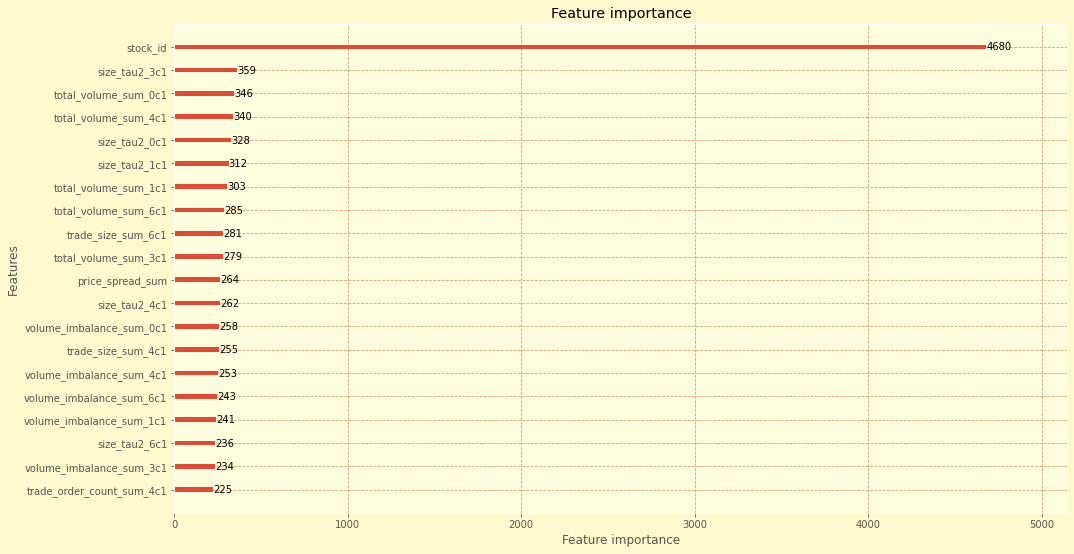

In [37]:
import gc
del mat1,mat2
gc.collect()
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
#         model = lgb.train(params = params,
#                           num_boost_round=1000,
#                           train_set = train_dataset, 
#                           valid_sets = [train_dataset, val_dataset], 
#                           verbose_eval = 250,
#                           early_stopping_rounds=50,
#                           feval = feval_rmspe)
        # Add predictions to the out of folds array
        model = joblib.load('../input/lgbm-most-fe-cv-194/'+f'model_fold{fold}.pkl')
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb= train_and_evaluate_lgb(train, test,params0)

## Best Public Ensemble

In [38]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed
import joblib
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [39]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    #train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    #train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    #print(f'Our training set has {train.shape[0]} rows')
    return test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [40]:
# Read train and test
train =pd.read_pickle("../input/myoptivertrainpkl/train.pkl")
test = read_train_test()

# Get unique stock ids 
#train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
#train_ = preprocessor(train_stock_ids, is_train = True)
#train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
#train = get_time_stock(train)
test = get_time_stock(test)

train1=train
test1=test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [41]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

194

In [42]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [43]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

In [44]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [45]:
import gc
del mat1,mat2
gc.collect()

6428

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429065	training's RMSPE: 0.198434	valid_1's rmse: 0.000440289	valid_1's RMSPE: 0.204357
[500]	training's rmse: 0.000407399	training's RMSPE: 0.188414	valid_1's rmse: 0.000425992	valid_1's RMSPE: 0.197722
[750]	training's rmse: 0.000393717	training's RMSPE: 0.182086	valid_1's rmse: 0.000418483	valid_1's RMSPE: 0.194236
[1000]	training's rmse: 0.00038396	training's RMSPE: 0.177574	valid_1's rmse: 0.000414271	valid_1's RMSPE: 0.192281
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.00038396	training's RMSPE: 0.177574	valid_1's rmse: 0.000414271	valid_1's RMSPE: 0.192281
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429401	training's RMSPE: 0.198936	valid_1's rmse: 0.000441304	valid_1's RMSPE: 0.2034
[500]	training's rmse: 0.00040727	training's RMSPE: 0.188683	valid_1's rmse: 0.000426268	valid_1's RMSPE

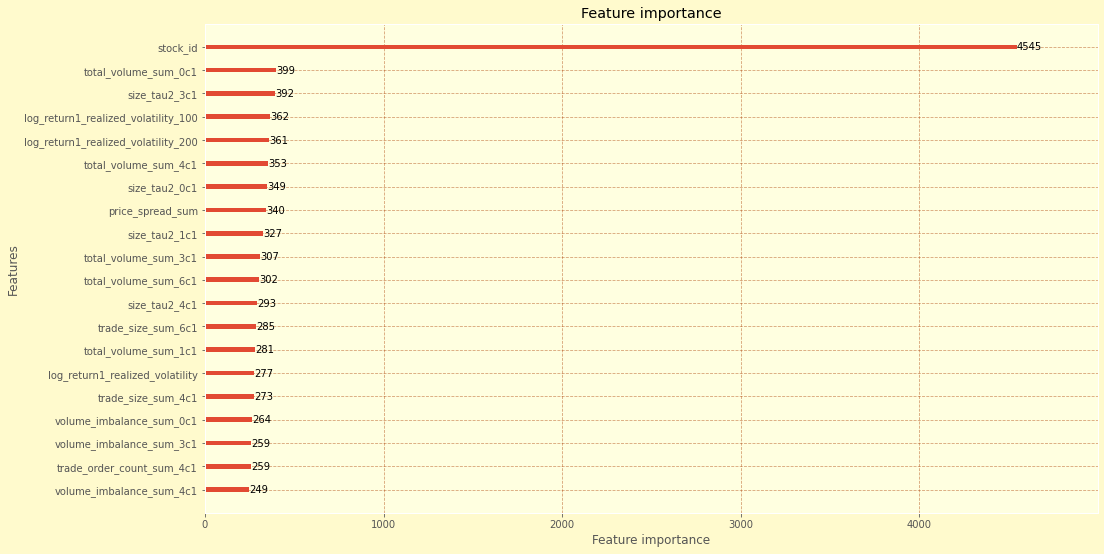

In [46]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        joblib.load('../input/optiverbestpublicmodel/'+f'model_lgbm_1_fold{fold}.pkl')
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb1= train_and_evaluate_lgb(train, test,params0)
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000428825	training's RMSPE: 0.198537	valid_1's rmse: 0.000446665	valid_1's RMSPE: 0.206425
[500]	training's rmse: 0.000407092	training's RMSPE: 0.188475	valid_1's rmse: 0.000432202	valid_1's RMSPE: 0.199741
[750]	training's rmse: 0.000393568	training's RMSPE: 0.182214	valid_1's rmse: 0.000424467	valid_1's RMSPE: 0.196166
[1000]	training's rmse: 0.000383016	training's RMSPE: 0.177328	valid_1's rmse: 0.000419386	valid_1's RMSPE: 0.193818
Did not meet early stopping. Best iteration is:
[1200]	training's rmse: 0.000376355	training's RMSPE: 0.174245	valid_1's rmse: 0.000416756	valid_1's RMSPE: 0.192603
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000430406	training's RMSPE: 0.199062	valid_1's rmse: 0.000459081	valid_1's RMSPE: 0.213045
[500]	training's rmse: 0.000408263	training's RMSPE: 0.188821	valid_1's rmse: 0.000444695	valid_1's 

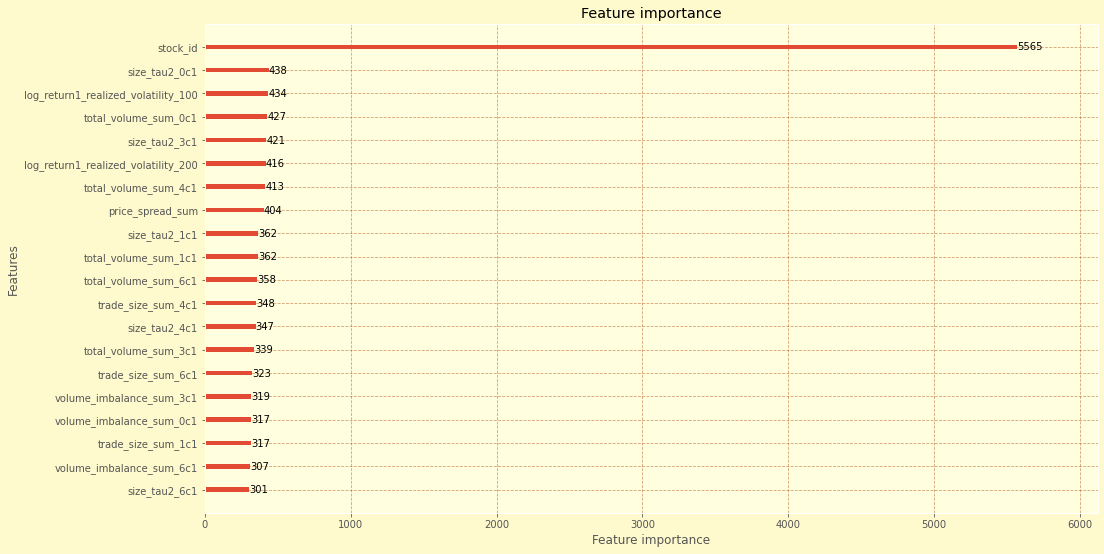

In [47]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=1111
params111 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1200,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        joblib.load('../input/optiverbestpublicmodel/'+f'model_lgbm_2_fold{fold}.pkl')
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb2= train_and_evaluate_lgb(train, test,params111)
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [48]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [49]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)
train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [50]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [51]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

In [52]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

In [53]:
import gc
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')

train1=train_nn
test1=test_nn
del mat1,mat2
del train,test
gc.collect()

12738

In [54]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(244,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [55]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [56]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), features_to_consider]
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    X_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), features_to_consider]
    y_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 3s 15ms/step - loss: 23.8191 - val_loss: 0.4237
Epoch 2/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.7082 - val_loss: 0.6480
Epoch 3/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5141 - val_loss: 0.6136
Epoch 4/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.4024 - val_loss: 0.7761
Epoch 5/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.7598 - val_loss: 0.8851
Epoch 6/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.6497 - val_loss: 0.7306
Epoch 7/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.7249 - val_loss: 0.5537
Epoch 8/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5390 - val_loss: 0.4897
Epoch 9/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.2552 - val_loss: 0.2172
Epoch 10/1000
168/168 [==============================] - 2s 13ms/

In [57]:
from numpy.random import seed
seed(2021)
import tensorflow as tf
tf.random.set_seed(2021)
from tensorflow import keras

target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2021)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train1)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train1[features_to_consider] = train1[features_to_consider].fillna(train1[features_to_consider].mean())
test1[features_to_consider] = test1[features_to_consider].fillna(train1[features_to_consider].mean())

train1[pred_name] = 0
test1[target_name] = 0
test_predictions_nn1 = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train1.loc[train1.time_id.isin(indexes), features_to_consider]
    y_train = train1.loc[train1.time_id.isin(indexes), target_name]
    X_test = train1.loc[train1.time_id.isin(values[n_count]), features_to_consider]
    y_test = train1.loc[train1.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn1 += model.predict([test1['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 3s 14ms/step - loss: 26.2109 - val_loss: 1.2451
Epoch 2/1000
168/168 [==============================] - 2s 12ms/step - loss: 1.2210 - val_loss: 0.6841
Epoch 3/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.6329 - val_loss: 0.7802
Epoch 4/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.6071 - val_loss: 0.6644
Epoch 5/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.5914 - val_loss: 2.3615
Epoch 6/1000
168/168 [==============================] - 2s 13ms/step - loss: 1.0008 - val_loss: 0.4440
Epoch 7/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5367 - val_loss: 0.5873
Epoch 8/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5365 - val_loss: 0.5057
Epoch 9/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.6116 - val_loss: 0.8302
Epoch 10/1000
168/168 [==============================] - 2s 13ms/

In [58]:
test=pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
a=test_predictions_nn*0.57+predictions_lgb2*0.43*0.985
b=test_predictions_nn1*0.57*0.986+predictions_lgb1*0.43
c = (nn_pres*0.987 +predictions_lgb+model1_predictions)/3
test[target_name] = (a+b+c)/3

display(test[['row_id', target_name]].head(3))
test[['row_id', target_name]].to_csv('submission.csv',index = False)
#test[['row_id', target_name]].to_csv('submission.csv',index = False)
#kmeans N=5 [0.2101, 0.21399, 0.20923, 0.21398, 0.21175]

,row_id,target
0,0-4,0.002513
1,0-32,0.002156
2,0-34,0.002156


In [59]:
test[['row_id', target_name]].to_csv('submission.csv',index = False)